## NN.ipynb

In [49]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Optional, List, Tuple, Dict


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


class Transform(object):
    """
    This is the base class. You do not need to change anything.
    Read the comments in this class carefully.
    """
    def __init__(self):
        """
        Initialize any parameters
        """
        pass

    def forward(self, x):
        """
        x should be passed as column vectors
        """
        pass

    def backward(self, grad_wrt_out):
        """
        Compute and save the gradients wrt the parameters for step()
        Return grad_wrt_x which will be the grad_wrt_out for previous Transform
        """
        pass

    def step(self):
        """
        Apply gradients to update the parameters
        """
        pass

    def zerograd(self):
        """
        This is used to Reset the gradients.
        Usually called before backward()
        """
        pass


class ReLU(Transform):
    def __init__(self):
        super(ReLU, self).__init__()

    def forward(self, x):
        """
        x shape (indim, batch_size)
        return shape (indim, batch_size)
        """
        self.input = x
        result = torch.maximum(torch.zeros_like(x), x)
        #print("i pass relu forward!")
        return result
        
    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        1 for x>0, 0 for x<=0
        """
        #chain rule of Relu
        grad_wrt_x = (self.input > 0).float() * grad_wrt_out
        #print("i pass relu backward!")
        return grad_wrt_x
    
class LinearMap(Transform):
    def __init__(self, indim, outdim, lr=0.01):
        """
        indim: input dimension
        outdim: output dimension
        lr: learning rate
        """
        super(LinearMap, self).__init__()
        self.weights = 0.01 *torch.rand((outdim, indim), dtype=torch.float64, requires_grad=True, device=device)
        self.bias = 0.01 * torch.rand((outdim, 1), dtype=torch.float64, requires_grad=True, device=device)
        self.lr = lr
        self.input = None
 
    def forward(self, x):
        """
        x shape (indim, batch_size) (64,60)
        return tensor shape (outdim, batch_size)
        L(x) = Wx+b
        """
        self.input = x.to(dtype=torch.float64)
        #print("i pass linear forward!")
        result = torch.mm(self.weights, self.input) + self.bias
        #print("linear forward result shape: ", result.size())
        return result

    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        return shape (indim, batch_size)
        """
        #compute grad_wrt_weights (outdim, batch_size) @ (batch_size, indim) -> (outdim, indim)
        self.grad_wrt_weights = torch.mm(grad_wrt_out,self.input.T)
        #compute grad_wrt_bias (outdim,1)
        self.grad_wrt_bias = grad_wrt_out.sum(dim=1, keepdim=True)
        #compute & return grad_wrt_input (indim,outdim)*(outdim, batch_size) = (indim, batch_size)
        grad_wrt_input = torch.mm(self.weights.T, grad_wrt_out)

        return grad_wrt_input

    def step(self):
        """
        apply gradients calculated by backward() to update the parameters
        
        print("weight: ",self.weights.size())
        print("grad_wrt_weights: ",self.grad_wrt_weights.size())
        print("bias: ",self.bias.size())
        print("grad_wrt_bias: ",self.grad_wrt_bias) 
        """ 
        self.weights -= self.lr * self.grad_wrt_weights
        self.bias -= self.lr * self.grad_wrt_bias
    
    def zerograd(self):
        """
        Reset the gradients of the parameters.
        """
        self.grad_wrt_weights = None
        self.grad_wrt_bias = None
            
class SoftmaxCrossEntropyLoss(object):
    def forward(self, logits, labels):
        """
        logits are pre-softmax scores => z
        labels are one-hot labels of given inputs => y
        logits and labels are in the shape of (num_classes, batch_size)
        returns loss as a scalar (i.e. mean value of the batch_size loss)
        """
        self.labels = labels
        self.logits = logits
        # Softmax calculation
        exps = torch.exp(logits - torch.max(logits, dim=0, keepdim=True)[0]) # e^z-max(z)
        self.probs = exps / torch.sum(exps, dim=0, keepdim=True) # e^z-max(z)/sum(e^z-max(z))

        # Cross-entropy loss
        log_likelihood = -torch.log(self.probs + 1e-9)
        loss = torch.sum(log_likelihood * self.labels) / labels.size(1)
        
        return loss

    def backward(self):
        """
        return grad_wrt_logits shape (num_classes, batch_size)
        (don't forget to divide by batch_size because your loss is a mean)
        """
        self.batch_size = self.logits.shape[1]
        grad_wrt_logits = (self.probs - self.labels) / self.batch_size
        return grad_wrt_logits
        
    def getAccu(self,correct_train,total_train,epoch_acc):
        """
        return accuracy here
        """      
        predictions = torch.argmax(self.probs, dim=0)
        correct_train += (predictions == torch.argmax(self.labels, dim=0)).sum().item()
        total_train += self.labels.shape[1]
        accuracy = correct_train/total_train
        
        return accuracy
            
class SingleLayerMLP(Transform):
    """constructing a single layer neural network with the previous functions"""
    def __init__(self, indim, outdim, hidden_layer=100, lr=0.01):
        super(SingleLayerMLP, self).__init__()
        #first layer linear transformation
        self.linear1 = LinearMap(indim, hidden_layer, lr)
        #Relu activation
        self.relu = ReLU()
        #second linear transformation
        self.linear2 = LinearMap(hidden_layer, outdim, lr)
        #learning rate
        self.lr = lr

    def forward(self, x):
        """
        x shape (indim, batch_size)
        return the presoftmax logits shape(outdim, batch_size)
        """
        q = self.linear1.forward(x)
        h = self.relu.forward(q)
        o = self.linear2.forward(h)
        return o

    def backward(self, grad_wrt_out):
        """
        grad_wrt_out shape (outdim, batch_size)
        calculate the gradients wrt the parameters
        """
        grad_wrt_hidden = self.linear2.backward(grad_wrt_out)
        grad_wrt_relu = self.relu.backward(grad_wrt_hidden)
        grad_wrt_input = self.linear1.backward(grad_wrt_relu)
        return grad_wrt_input

    def step(self):
        """update model parameters"""
        self.linear1.step()
        self.linear2.step()
        
    def zerograd(self):
        """
        Reset the gradients for all layers of the model.
        """
        self.linear1.zerograd()
        self.linear2.zerograd()
        
class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        self.X = X
        self.Y = Y

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length

def labels2onehot(labels: np.ndarray):
    return np.array([[i==lab for i in range(2)] for lab in labels]).astype(int)



In [50]:
if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need plot the loss and accuracies during the training process and test process. 
    """

    indim = 60
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 500

    #dataset
    Xtrain = pd.read_csv("./data/X_train.csv")
    Ytrain = pd.read_csv("./data/y_train.csv")
    scaler = MinMaxScaler()
    Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).to_numpy()
    Ytrain = np.squeeze(Ytrain)
    m1, n1 = Xtrain.shape
    print(m1, n1)
    train_ds = DS(Xtrain, Ytrain)
    train_loader = DataLoader(train_ds, batch_size=batch_size)

    Xtest = pd.read_csv("./data/X_test.csv")
    Ytest = pd.read_csv("./data/y_test.csv")
    Xtest = pd.DataFrame(scaler.fit_transform(Xtest), columns=Xtest.columns).to_numpy()
    Ytest = np.squeeze(Ytest)
    m2, n2 = Xtest.shape
    print(m1, n2)
    test_ds = DS(Xtest, Ytest)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    #construct the model
    model = SingleLayerMLP(indim, outdim, hidden_dim, lr)
    loss_function = SoftmaxCrossEntropyLoss()
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        #Training
        epoch_train_losses = []
        correct_train = 0
        total_train = 0
        epoch_acc = []
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.float().to(device)
            y_batch = labels2onehot(y_batch.numpy()).T 
            y_batch = torch.from_numpy(y_batch).float().to(device)
                
            # Forward pass + loss 
            logits = model.forward(x_batch.T)
            loss = loss_function.forward(logits, y_batch) 
            epoch_train_losses.append(loss.item())

            # Backward pass
            model.zerograd()
            grad_wrt_out = loss_function.backward()
            model.backward(grad_wrt_out)
            model.step()
            
            # Calculate accuracy
            accuracy = loss_function.getAccu(correct_train,total_train,epoch_acc)
            epoch_acc.append(accuracy)
            
        # Calculate and store average training loss for this epoch
        avg_train_loss = np.mean(epoch_train_losses)
        train_accuracy = np.mean(epoch_acc)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Testing 
        correct_test = 0
        total_test = 0
        epoch_test_losses = []
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.float().to(device)
            y_batch = labels2onehot(y_batch.numpy()).T
            y_batch = torch.from_numpy(y_batch).float().to(device)
            # Calculate test loss
            logits = model.forward(x_batch.T)
            loss = loss_function.forward(logits, y_batch)  
            epoch_test_losses.append(loss.item())
            
            predictions = torch.argmax(logits, dim=0)
            correct_test += (predictions == torch.argmax(y_batch, dim=0)).sum().item()
            total_test += y_batch.shape[1]
        
        test_accuracy = correct_test / total_test
        test_accuracies.append(test_accuracy)
        
        # Calculate and store average testing loss for this epoch
        avg_test_loss = np.mean(epoch_test_losses)
        test_losses.append(avg_test_loss)
        
        avg_loss = (avg_test_loss+avg_train_loss)/2
        #print(f"Epoch {epoch+1}: Loss {avg_loss:.4f}, Train Accuracy {train_accuracy:.4f}, Test Accuracy {test_accuracy:.4f}")
                


1500 60
1500 60


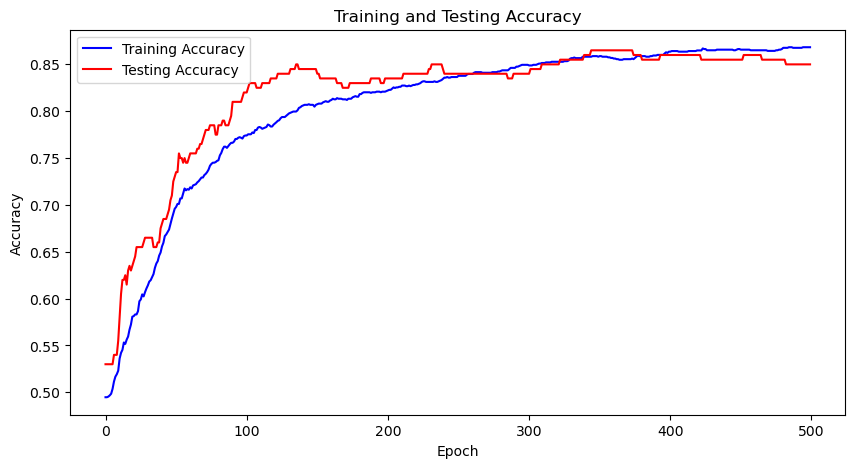

In [51]:
import matplotlib.pyplot as plt

# Plot training and testing accuracy on the same plot
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(train_accuracies, label='Training Accuracy', color='blue')

# Plot testing accuracy
plt.plot(test_accuracies, label='Testing Accuracy', color='red')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()


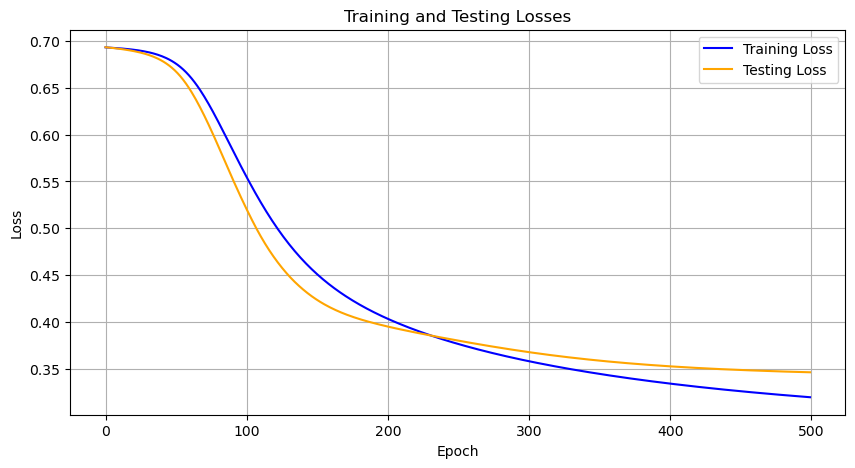

In [42]:
import matplotlib.pyplot as plt

# Plotting the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()


## Reference.ipynb

In [43]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from typing import Optional, List, Tuple, Dict
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class SingleLayerMLP(nn.Module):
    """Constructing a single layer neural network with PyTorch"""
    def __init__(self, indim, outdim, hidden_layer=100):
        super(SingleLayerMLP, self).__init__()
        self.linear1 = nn.Linear(indim, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, outdim)
        
    def forward(self, x):
        """
        x shape (batch_size, indim)
        """
        result = self.linear2(F.relu(self.linear1(x)))
        return result

class DS(Dataset):
    def __init__(self, X: np.ndarray, Y: np.ndarray):
        self.length = len(X)
        if isinstance(X, pd.DataFrame):
            X = X.values
        if isinstance(Y, pd.Series) or isinstance(Y, pd.DataFrame):
            Y = Y.values
        
        self.X = torch.tensor(X, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.long)

    def __getitem__(self, idx):
        x = self.X[idx, :]
        y = self.Y[idx]
        return (x, y)

    def __len__(self):
        return self.length

def validate(loader, model, criterion,optimizer):
    #loss calculation
    running_loss = 0.0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    
    avg_loss = running_loss / len(loader)
    #accuracy calculation
    _, predicted = torch.max(outputs, 1)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader:
            input, labels = data
            outputs = model(input)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
   
    return avg_loss, accuracy

    

In [47]:
if __name__ == "__main__":
    """The dataset loaders were provided for you.
    You need to implement your own training process.
    You need plot the loss and accuracies during the training process and test process. 
    """

    indim = 60
    outdim = 2
    hidden_dim = 100
    lr = 0.01
    batch_size = 64
    epochs = 500

    # Dataset
    Xtrain = pd.read_csv("./data/X_train.csv")
    Ytrain = pd.read_csv("./data/y_train.csv")
    scaler = MinMaxScaler()
    Xtrain = pd.DataFrame(scaler.fit_transform(Xtrain), columns=Xtrain.columns).to_numpy()
    Ytrain = np.squeeze(Ytrain)
    m1, n1 = Xtrain.shape
    print(m1, n1)
    train_ds = DS(Xtrain, Ytrain)
    train_loader = DataLoader(train_ds, batch_size=batch_size)

    Xtest = pd.read_csv("./data/X_test.csv")
    Ytest = pd.read_csv("./data/y_test.csv").to_numpy()
    Xtest = pd.DataFrame(scaler.fit_transform(Xtest), columns=Xtest.columns.to_numpy())
    Ytest = np.squeeze(Ytest)
    m2, n2 = Xtest.shape
    print(m1, n2)
    test_ds = DS(Xtest, Ytest)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    #create model/optimizer/criterion
    model = SingleLayerMLP(indim, outdim, hidden_dim)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    #training
    for epoch in range(epochs):  
        train_avg_loss, train_accuracy = validate(train_loader, model, criterion, optimizer)
        test_avg_loss, test_accuracy = validate(test_loader, model, criterion, optimizer)

        #print(f'Epoch [{epoch+1}/{epochs}], train Loss: {train_avg_loss:.4f}, train Accuracy : {train_accuracy:.2f} ')
        #print(f'Epoch [{epoch+1}/{epochs}], test Loss: {test_avg_loss:.4f}, test Accuracy : {test_accuracy:.2f} ')
        
        train_losses.append(train_avg_loss)
        test_losses.append(test_avg_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)


   

1500 60
1500 60


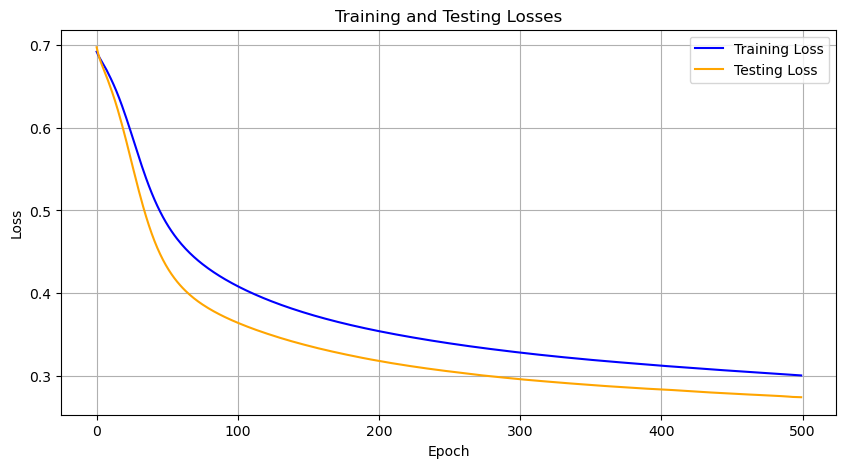

In [45]:
import matplotlib.pyplot as plt

# Plotting the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Testing Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()
plt.grid(True)
plt.show()

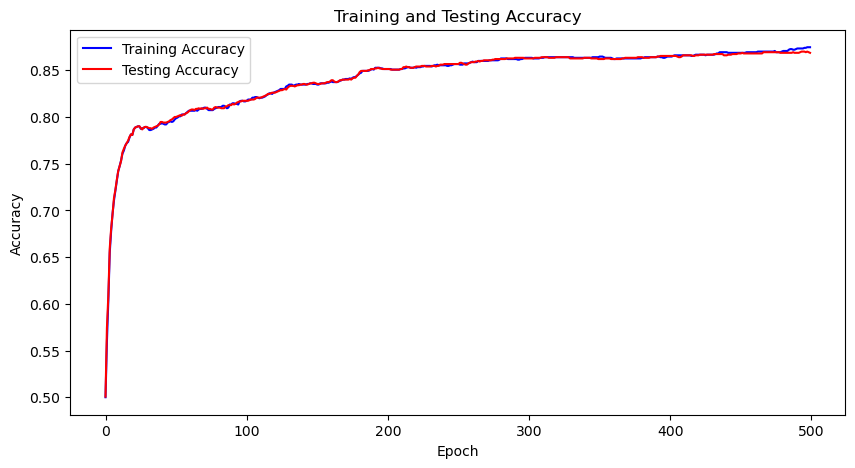

In [46]:
# Plot training and testing accuracy on the same plot
plt.figure(figsize=(10, 5))

# Plot training accuracy
plt.plot(train_accuracies, label='Training Accuracy', color='blue')

# Plot testing accuracy
plt.plot(test_accuracies, label='Testing Accuracy', color='red')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()
